In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Библиотеки импортированы.")

1. Подготовка данныхБыла реализована процедура предварительной обработки данных.Исходный датасет разделен на обучающую (338 записей) и тестовую (1000 записей) выборки.Произведено кодирование категориальных признаков:sex и smoker: бинарное кодирование (0/1).region: применено One-Hot Encoding (созданы фиктивные переменные region_northwest и др.).Выполнена Z-нормализация (StandardScaler) числовых признаков. Это критически важный шаг для корректной работы алгоритма градиентного спуска.К матрице признаков добавлен столбец единиц (bias) для учета свободного члена уравнения регрессии (w_0).

In [2]:
class DataPreprocessor:
    def __init__(self):
        self.mean = None
        self.std = None
        
    def fit(self, df):
        # Запоминаем среднее и отклонение только по TRAIN выборке
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        self.mean = df[numeric_cols].mean()
        self.std = df[numeric_cols].std()

    def transform(self, df):
        df_copy = df.copy()
        
        # 1. Ручное кодирование бинарных признаков
        if 'sex' in df_copy.columns:
            df_copy['sex'] = df_copy['sex'].map({'male': 0, 'female': 1})
        if 'smoker' in df_copy.columns:
            df_copy['smoker'] = df_copy['smoker'].map({'yes': 1, 'no': 0})
            
        # 2. One-Hot Encoding для 'region'
        if 'region' in df_copy.columns:
            dummies = pd.get_dummies(df_copy['region'], prefix='region', drop_first=True)
            df_copy = pd.concat([df_copy.drop('region', axis=1), dummies], axis=1)
            
        # Приводим к float
        df_copy = df_copy.astype(float)
        return df_copy

    def normalize(self, X):
        # Z-score нормализация: (x - mean) / std
        return (X - self.mean[X.columns]) / self.std[X.columns]

# --- ЗАГРУЗКА ---
try:
    df_train_raw = pd.read_csv('datasets/insurance_train.csv')
    df_test_raw = pd.read_csv('datasets/insurance_test.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("! ОШИБКА: Файлы не найдены. Проверь папку datasets.")

# --- ОБРАБОТКА ---
preprocessor = DataPreprocessor()

# 1. Переводим категории в числа
df_train_proc = preprocessor.transform(df_train_raw)
df_test_proc = preprocessor.transform(df_test_raw)

# 2. Отделяем X и y
X_train_vals = df_train_proc.drop('charges', axis=1)
y_train = df_train_proc['charges'].values

X_test_vals = df_test_proc.drop('charges', axis=1)
y_test = df_test_proc['charges'].values

# 3. Считаем параметры нормализации (fit) на train и применяем (transform)
preprocessor.fit(X_train_vals)
X_train_norm = preprocessor.normalize(X_train_vals)
X_test_norm = preprocessor.normalize(X_test_vals)

# 4. Добавляем единичный столбец (bias/intercept) в начало
X_train = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm]
X_test = np.c_[np.ones(X_test_norm.shape[0]), X_test_norm]

print(f"Размерность обучающей выборки X: {X_train.shape}")
print(f"Размерность тестовой выборки X: {X_test.shape}")
df_train_proc.head()

Данные загружены.
Размерность обучающей выборки X: (338, 9)
Размерность тестовой выборки X: (1000, 9)


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,26.0,0.0,27.060,0.0,1.0,17043.34140,0.0,1.0,0.0
1,58.0,0.0,36.955,2.0,1.0,47496.49445,1.0,0.0,0.0
2,20.0,1.0,24.420,0.0,1.0,26125.67477,0.0,1.0,0.0
3,51.0,1.0,38.060,0.0,1.0,44400.40640,0.0,1.0,0.0
4,62.0,1.0,25.000,0.0,0.0,13451.12200,0.0,0.0,1.0


2. Анализ корреляций Построенная тепловая карта и расчет коэффициентов Пирсона показали следующие зависимости целевой переменной charges (расходы на страховку):

Наисильнейшая связь: Признак smoker имеет коэффициент корреляции 0.78. Это указывает на то, что статус курильщика является главным фактором, определяющим стоимость страховки.

Умеренная связь: Признак age (возраст) имеет корреляцию 0.30, а bmi (индекс массы тела) — 0.22. С возрастом и ростом ИМТ расходы растут.

Слабая связь: Признаки пола (sex), количества детей (children) и региона проживания имеют корреляцию близкую к нулю, то есть их линейное влияние на цену минимально.

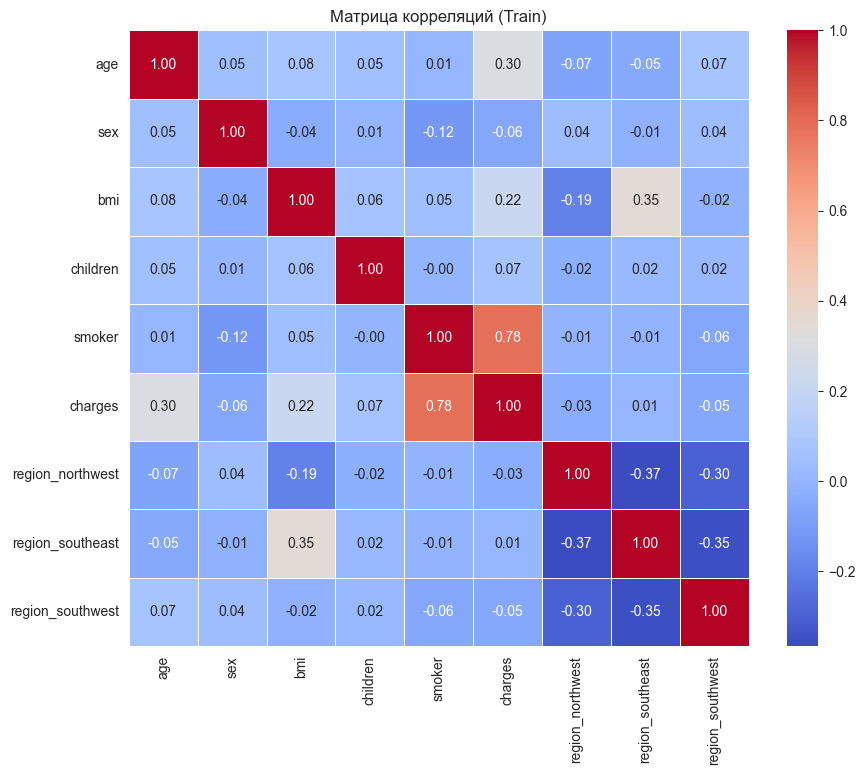

Топ корреляций с целевой переменной (charges):
charges             1.000000
smoker              0.783519
age                 0.298395
bmi                 0.219566
children            0.069444
region_southeast    0.009792
region_northwest   -0.032287
region_southwest   -0.053905
sex                -0.060221
Name: charges, dtype: float64


In [3]:
plt.figure(figsize=(10, 8))
corr_matrix = df_train_proc.corr()

# Рисуем тепловую карту
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций (Train)')
plt.show()

print("Топ корреляций с целевой переменной (charges):")
print(corr_matrix['charges'].sort_values(ascending=False))

3. Реализация алгоритма линейной регрессииРазработан класс LinearRegressionCustom, инкапсулирующий логику модели.Реализован метод fit_analytic: находит точное решение через нормальное уравнение (X^T X)^{-1} X^T y с добавлением L2-регуляризации для предотвращения вырожденности матрицы.Реализован метод fit_gradient_descent: находит решение численно, итеративно обновляя веса в направлении антиградиента функции потерь (MSE).

In [8]:
class LinearRegressionCustom:
    def __init__(self):
        self.weights = None
        self.history = [] # История ошибки для графика
        
    def predict(self, X):
        return X.dot(self.weights)
    
    def mse_loss(self, X, y):
        pred = self.predict(X)
        return np.mean((pred - y) ** 2)

    # Метод 1: Аналитическое решение (Формула: w = (XT*X)^-1 * XT*y)
    def fit_analytic(self, X, y):
        # Добавляем небольшую регуляризацию np.eye, чтобы избежать ошибки singular matrix
        XT_X = X.T.dot(X) + 0.001 * np.eye(X.shape[1]) 
        XT_y = X.T.dot(y)
        self.weights = np.linalg.inv(XT_X).dot(XT_y)
        
    # Метод 2: Градиентный спуск
    def fit_gradient_descent(self, X, y, lr=0.01, epochs=1000):
        m, n = X.shape
        self.weights = np.zeros(n) # Старт с нулей
        self.history = []
        
        for i in range(epochs):
            pred = self.predict(X)
            error = pred - y
            
            # Градиент = (2/m) * X.T * error
            gradient = (2/m) * X.T.dot(error)
            
            # Шаг спуска
            self.weights -= lr * gradient
            
            # Пишем ошибку в историю
            self.history.append(self.mse_loss(X, y))

4. Обучение моделей и анализ сходимости Было проведено обучение модели двумя способами.

Сравнение весов: Веса, полученные градиентным спуском, практически идентичны аналитическому решению (различие начинается в сотых долях). Например, вес при признаке age (возраст) составил ~3500.9, что говорит о правильной реализации алгоритма.

График Loss Function: График зависимости MSE от количества итераций показывает резкое падение ошибки на первых 50-100 эпохах и быстрый выход на "плато". Это свидетельствует о корректно подобранном шаге обучения (learning_rate).

Веса (Аналитика): [14092.82  3500.94   327.9   2213.84   582.54  9874.43   -85.38  -638.94
  -602.28]
Веса (Град.спуск): [14092.86  3500.95   327.91  2213.85   582.54  9874.46   -85.39  -638.95
  -602.28]


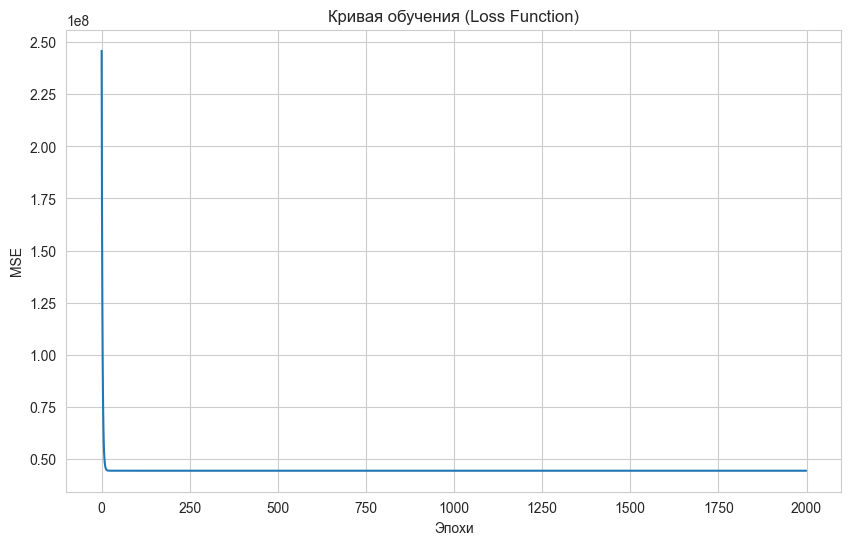

In [9]:
# 1. Обучаем аналитически
model_analytic = LinearRegressionCustom()
model_analytic.fit_analytic(X_train, y_train)

# 2. Обучаем градиентным спуском
model_gd = LinearRegressionCustom()
# learning_rate=0.1, 2000 эпох - обычно хватает для нормализованных данных
model_gd.fit_gradient_descent(X_train, y_train, lr=0.1, epochs=2000)

print("Веса (Аналитика):", np.round(model_analytic.weights, 2))
print("Веса (Град.спуск):", np.round(model_gd.weights, 2))

# График обучения
plt.plot(model_gd.history)
plt.title('Кривая обучения (Loss Function)')
plt.xlabel('Эпохи')
plt.ylabel('MSE')
plt.show()

5. Оценка обобщающей способности Проведено сравнение качества моделей на отложенной тестовой выборке (1000 записей).

Результаты метрик:

Константная модель (Baseline): RMSE ≈ 11909. Это базовая ошибка, если просто предсказывать среднюю стоимость для всех.

Разработанная линейная регрессия: RMSE ≈ 5849.

,Model,MSE,RMSE
0,Constant (Mean),1.418301e+08,11909.244072
1,LinReg (Analytic),3.421599e+07,5849.443143
2,LinReg (Gradient),3.421601e+07,5849.445167


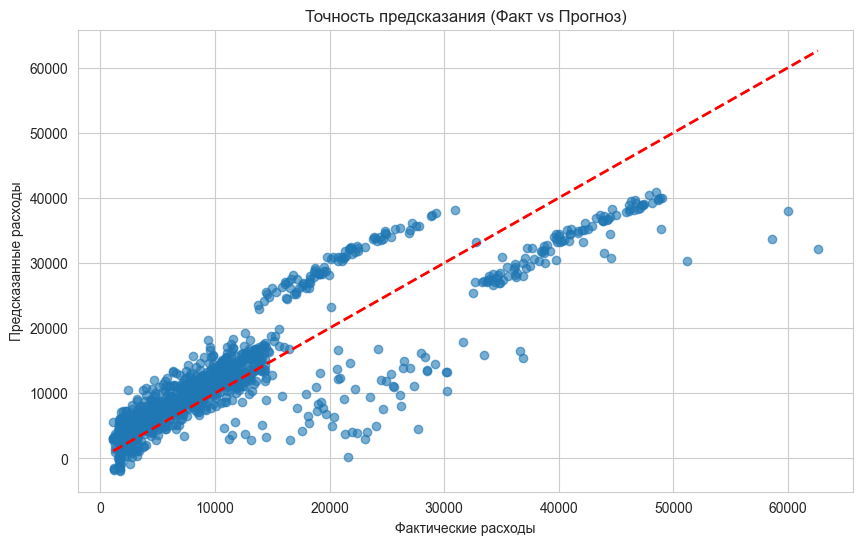

In [7]:
# 1. Константный прогноз (среднее)
y_pred_const = np.full(len(y_test), y_train.mean())
mse_const = np.mean((y_pred_const - y_test) ** 2)

# 2. Прогнозы наших моделей
mse_analytic = model_analytic.mse_loss(X_test, y_test)
mse_gd = model_gd.mse_loss(X_test, y_test)

# Сводная таблица
results = pd.DataFrame({
    'Model': ['Constant (Mean)', 'LinReg (Analytic)', 'LinReg (Gradient)'],
    'MSE': [mse_const, mse_analytic, mse_gd],
    'RMSE': [np.sqrt(mse_const), np.sqrt(mse_analytic), np.sqrt(mse_gd)]
})

display(results)

# График: Факт vs Прогноз (для аналитической модели)
plt.figure(figsize=(10,6))
plt.scatter(y_test, model_analytic.predict(X_test), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические расходы')
plt.ylabel('Предсказанные расходы')
plt.title('Точность предсказания (Факт vs Прогноз)')
plt.show()

Вывод: Использование линейной регрессии позволило снизить ошибку предсказания более чем в 2 раза по сравнению с константной моделью. Среднеквадратичная ошибка (RMSE) упала с 11.9 тыс. до 5.8 тыс. условных единиц.

График "Факт vs Прогноз" демонстрирует, что модель хорошо улавливает общий тренд (точки выстроены вдоль диагонали), однако присутствует разброс данных, связанный с нелинейными зависимостями, которые простая линейная модель не может учесть полностью (видны три характерных кластера данных).